In [1]:
%pylab inline
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'car_data.csv'
df = pd.read_csv(filename)
print(df.columns)


Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [4]:
print(set(df['num-of-cylinders']))
print(set(df['num-of-doors']))

{'eight', 'two', 'four', 'five', 'twelve', 'six', 'three'}
{'?', 'two', 'four'}


In [5]:
 # get all columns but symboling and normalized-losses
df = df.loc[:, (df.columns != 'symboling') & (df.columns != 'normalized-losses')]

# get all rows without missing data
valid = df.select_dtypes(include=['object']) != '?'
valid_idx = (valid).all(axis=1)

# get valid row and separate out columns as necessary

def numstr2int(st):
    mappings = {'twelve':12, 'four':4, 'two':2, 'five':5, 'six':6, 'eight':8, 'three':3}
    return mappings[st]

df = df.loc[valid_idx]
df['price'] = df['price'].apply(lambda x: float(x))
df['num-of-doors'] = df['num-of-doors'].apply(numstr2int)
df['peak-rpm'] = df['peak-rpm'].apply(lambda x: int(x))
df['horsepower'] = df['horsepower'].apply(lambda x: int(x))
df['stroke'] = df['stroke'].apply(lambda x: float(x))
df['bore'] = df['bore'].apply(lambda x: float(x))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(numstr2int)
target = df['price']

inputs = df.loc[:, :'highway-mpg']

In [6]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 23 columns):
make                 193 non-null object
fuel-type            193 non-null object
aspiration           193 non-null object
num-of-doors         193 non-null int64
body-style           193 non-null object
drive-wheels         193 non-null object
engine-location      193 non-null object
wheel-base           193 non-null float64
length               193 non-null float64
width                193 non-null float64
height               193 non-null float64
curb-weight          193 non-null int64
engine-type          193 non-null object
num-of-cylinders     193 non-null int64
engine-size          193 non-null int64
fuel-system          193 non-null object
bore                 193 non-null float64
stroke               193 non-null float64
compression-ratio    193 non-null float64
horsepower           193 non-null int64
peak-rpm             193 non-null int64
city-mpg             193 non-null

In [7]:
columns_to_encode = ['make', 'fuel-type','aspiration', 'body-style','drive-wheels',
                     'engine-location','engine-type','fuel-system']
for col in columns_to_encode:
    print(f'handling {col}')
    dummy = pd.get_dummies(df[col])
    #print(dummy)
    inputs = inputs.join(dummy)
inputs = inputs.drop(columns_to_encode, axis=1)

handling make
handling fuel-type
handling aspiration
handling body-style
handling drive-wheels
handling engine-location
handling engine-type
handling fuel-system


In [8]:
X = inputs.values
y = target.values

In [29]:
k_fold = KFold(n_splits=5)
k_fold.get_n_splits(X)

5

In [30]:
errors = []
for train_idx, test_idx in k_fold.split(X):
    train_X, test_X = X[train_idx], X[test_idx]
    train_y, test_y = y[train_idx], y[test_idx]
    lr = linear_model.Ridge()
    lr.fit(train_X, train_y)
    predictions = lr.predict(test_X)
    error = np.mean(np.abs(predictions - test_y)/test_y * 100) # mean average percentage error
    errors.append(error)
print(np.mean(errors))
print(np.std(errors))
print(errors)
        

26.2043705679
3.72178084313
[30.701718229446694, 19.402018500508067, 27.443328902582827, 27.310494255949571, 26.164292951097408]


In [31]:
lr.coef_

array([ -4.87501547e+00,   1.70720135e+02,  -5.47574935e+01,
         4.83752229e+02,   1.48626537e+01,   2.99293844e+00,
        -1.72486140e+02,   1.15286934e+02,  -2.33845178e+03,
        -5.55159947e+02,  -1.17852221e+02,   3.52883486e+01,
         1.63860799e+00,  -2.53173677e+01,   2.25507668e+02,
        -2.87915101e+01,   1.06854559e+03,   4.20564457e+03,
        -1.86103701e+02,  -1.23501754e+03,  -4.48129214e+01,
        -6.42976167e+02,  -1.97667070e+03,   1.29419027e+02,
         3.80702541e+03,  -1.66883235e+03,  -1.74870054e+03,
        -1.04872978e+03,  -2.08809893e+03,  -1.53157005e+03,
         2.38218165e+03,   1.27407588e+03,  -4.68519584e+02,
        -1.98068350e+02,   0.00000000e+00,   0.00000000e+00,
         2.39472045e+02,  -2.39472045e+02,  -3.20120428e+02,
         3.20120428e+02,   2.52433251e+03,   1.21244181e+03,
        -1.48794515e+03,  -9.60514926e+02,  -1.28831424e+03,
         3.23191890e+02,  -1.03312442e+03,   7.09932529e+02,
        -1.83814491e+03,

In [32]:
model = InMemoryModel(lr.predict, examples = X)

In [33]:
interpreter = Interpretation(X, feature_names=inputs.columns)

[62/62] features ████████████████████ Time elapsed: 1 seconds

(<matplotlib.figure.Figure at 0x115d36358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11663aa20>)

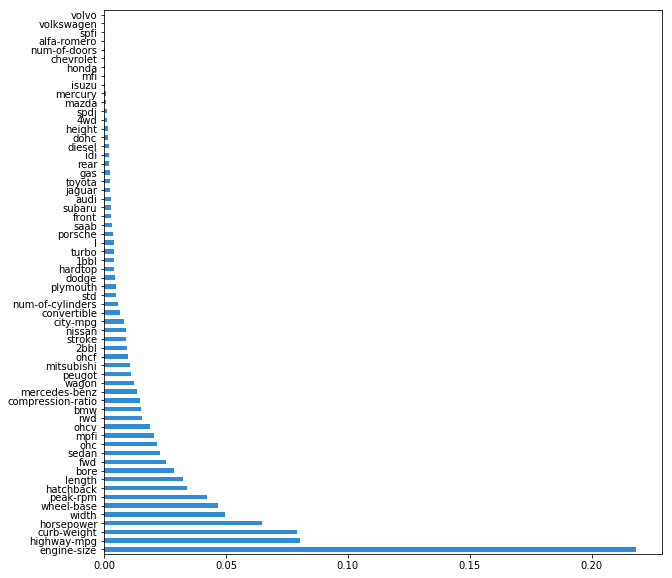

In [34]:
matplotlib.rcParams['figure.figsize'] = [10, 10]
interpreter.feature_importance.plot_feature_importance(model)